In [2]:
import numpy as np
import lmdb
import numpy as np
import torch
import six
from torch.utils.data import Dataset
import json
from PIL import Image

import matplotlib.pyplot as plt
from pathlib import Path
import cv2
from tqdm import trange

import albumentations as A
from albumentations import KeypointParams
from albumentations.pytorch import ToTensorV2

In [5]:
ROOT_DIR = Path().cwd().parents[2]

In [6]:
# indices
env = lmdb.open(str(ROOT_DIR / 'data' / 'data0004' / 'lmdb'), max_readers=32, readonly=True, lock=False, readahead=False, meminit=False)
with env.begin(write=False) as txn:
    n_samples = int(txn.get('num-samples'.encode()))

indices = []
with env.begin(write=False) as txn:
    for i in range(n_samples):
        # load json
        label_key = f'label-{str(i+1).zfill(8)}'.encode()
        label = txn.get(label_key).decode('utf-8')
        json_dict = json.loads(label)
        if json_dict['chart-type'] != 'scatter':
            continue
        indices.append(i)

In [28]:
LMDB_DIR = ROOT_DIR / 'data' / 'data0004' / 'lmdb'

class cfg:
    input_size = 3
    output_size = 1
    img_h = 512
    img_w = 768
    heatmap_h = 128
    heatmap_w = 196
    sigma = 1

In [19]:
def tensor2arr(tensor_img):
    if len(tensor_img.shape) == 2:
        tensor_img = tensor_img.unsqueeze(0)
    return tensor_img.permute(1, 2, 0).numpy() * np.array([0.2747, 0.2747, 0.2809]) + np.array([0.8578, 0.8552, 0.8507])

In [30]:
def is_nan(value):
    """
    Check if a value is NaN (not a number).

    Args:
        value (int, float, str): The value to check

    Returns:
        bool: True if the value is NaN, False otherwise
    """
    return isinstance(value, float) and np.isnan(value)

def round_float(value):
    """
    Convert a float value to a string with the specified number of decimal places. 
    If there is more than 1 digit in the integer, then we will truncate to 1 decimal.
    Otherwise, will truncate to 4 decimals.

    Args:
        value (int, float, str): The float value to convert

    Returns:
        str: The rounded float value as a string
    """
    if isinstance(value, float):
        value = str(value)

        if "." in value:
            integer, decimal = value.split(".")
            if abs(float(integer)) > 1:
                decimal = decimal[:1]
            else:
                decimal = decimal[:4]

            value = integer + "." + decimal
    return value

In [35]:
# Lmdb Dataset
class MgaLmdbDataset(Dataset):
    def __init__(self, cfg, lmdb_dir, indices, transforms, output_hm=True):
        super().__init__()
        self.cfg = cfg
        self.transforms = transforms
        self.indices = indices
        self.env = lmdb.open(str(lmdb_dir), max_readers=32,
                             readonly=True, lock=False, readahead=False, meminit=False)
        self.output_size = cfg.output_size
        self.sigma = cfg.sigma
        self.img_h, self.img_w = cfg.img_h, cfg.img_w
        self.heatmap_h, self.heatmap_w = cfg.heatmap_h, cfg.heatmap_w
        self.output_hm = output_hm
        self.chart2point_name = {
            'scatter': 'scatter points',
            'line': 'lines',
            'dot': 'dot points',
            'vertical_bar': 'bars',
            'horizontal_bar': 'bars',
        }
    
    def _json_dict_to_gt_string(self, json_dict):
        """
        Args:
            json_dict (Dict[str, Any]): ターゲットのdict
        Returns:
            gt_string (str): 入力となるプロンプト
        """
        all_x, all_y = [], []

        for d in json_dict['data-series']:
            x = d["x"]
            y = d["y"]

            x = round_float(x)
            y = round_float(y)

            # Ignore nan values
            if is_nan(x) or is_nan(y):
                continue

            all_x.append(x)
            all_y.append(y)

        return list(map(str, all_x)), list(map(str, all_y))

    def _overlap_heatmap(self, heatmap, center, sigma):
        tmp_size = sigma * 6
        mu_x = int(center[0] + 0.5)
        mu_y = int(center[1] + 0.5)
        w, h = heatmap.shape[0], heatmap.shape[1]
        ul = [int(mu_x - tmp_size), int(mu_y - tmp_size)]
        br = [int(mu_x + tmp_size + 1), int(mu_y + tmp_size + 1)]
        if ul[0] >= h or ul[1] >= w or br[0] < 0 or br[1] < 0:
            return heatmap
        size = 2 * tmp_size + 1
        x = np.arange(0, size, 1, np.float32)
        y = x[:, np.newaxis]
        x0 = y0 = size // 2
        g = np.exp(- ((x - x0) ** 2 + (y - y0) ** 2) / (2 * sigma ** 2))
        g_x = max(0, -ul[0]), min(br[0], h) - ul[0]
        g_y = max(0, -ul[1]), min(br[1], w) - ul[1]
        img_x = max(0, ul[0]), min(br[0], h)
        img_y = max(0, ul[1]), min(br[1], w)
        heatmap[img_y[0]:img_y[1], img_x[0]:img_x[1]] = np.maximum(
            heatmap[img_y[0]:img_y[1], img_x[0]:img_x[1]],
            g[g_y[0]:g_y[1], g_x[0]:g_x[1]])
        return heatmap

    def _create_heatmap(self, joints):
        '''
            joints: [(x1, y1), (x2, y2), ...]
            heatmap: size: (hm_h, hm_w)
        '''
        heatmap = np.zeros((self.heatmap_h, self.heatmap_w), dtype=np.float32)
        for joint_id in range(len(joints)):
            heatmap = self._overlap_heatmap(
                heatmap, joints[joint_id], self.sigma)
        return heatmap

    def _count_n_points(self, json_dict):
        """
        Args:
            json_dict (Dict[str, Any]): ターゲットのdict
        Returns:
            gt_string (str): 入力となるプロンプト
        """
        n_points = 0

        for d in json_dict['data-series']:
            x = d["x"]
            y = d["y"]
            # Ignore nan values
            if is_nan(x) or is_nan(y):
                continue
            n_points += 1

        return n_points

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        idx = self.indices[idx]
        with self.env.begin(write=False) as txn:
            # load image
            img_key = f'image-{str(idx+1).zfill(8)}'.encode()
            imgbuf = txn.get(img_key)

            # load json
            label_key = f'label-{str(idx+1).zfill(8)}'.encode()
            label = txn.get(label_key).decode('utf-8')

        # image
        buf = six.BytesIO()
        buf.write(imgbuf)
        buf.seek(0)
        if self.cfg.input_size == 3:
            img = np.array(Image.open(buf).convert('RGB'))
        else:
            img = np.array(Image.open(buf).convert('L'))
        h, w, _ = img.shape

        # label
        json_dict = json.loads(label)
        n_points = self._count_n_points(json_dict)
        x_list, y_list = self._json_dict_to_gt_string(json_dict)

        if self.output_hm:
            chart_type = json_dict['chart-type']
            point_name = self.chart2point_name[chart_type]

            keypoints = []
            for dic in json_dict['visual-elements'][point_name][0]:
                x, y = dic['x'], dic['y']
                if x < 0 or y < 0 or x > w or y > h:
                    continue
                keypoints.append([x, y])

            transformed = self.transforms(image=img, keypoints=keypoints)
            img = transformed['image']
            img = torch.from_numpy(img).permute(2, 0, 1)
            keypoints = transformed['keypoints']

            if len(keypoints) != 0:
                keypoints_on_hm = np.array(keypoints) * \
                    np.array([self.heatmap_w, self.heatmap_h]) / \
                    np.array([self.img_w, self.img_h])

                heatmap = self._create_heatmap(keypoints_on_hm)
            else:
                heatmap = np.zeros((self.heatmap_h, self.heatmap_w))

            heatmap = torch.from_numpy(heatmap)

            return img, heatmap, n_points, [x_list, y_list]
        else:
            transformed = self.transforms(image=img)
            img = transformed['image']
            img = torch.from_numpy(img).permute(2, 0, 1)
            return img, n_points

In [36]:
def get_transforms():
    return A.Compose([
        A.Resize(512, 768),
        A.Normalize([0.8578, 0.8552, 0.8507], [0.2747, 0.2747, 0.2809]),
    ], keypoint_params=KeypointParams(format='xy'))

In [51]:
ds = MgaLmdbDataset(cfg, LMDB_DIR, indices, get_transforms())

In [52]:
img, hm, n_points, [xs, ys] = ds.__getitem__(4)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


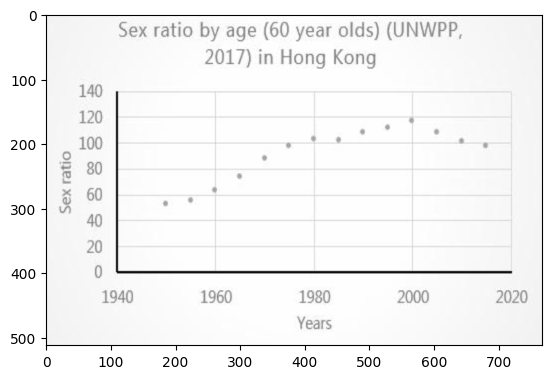

In [53]:
plt.imshow(tensor2arr(img))

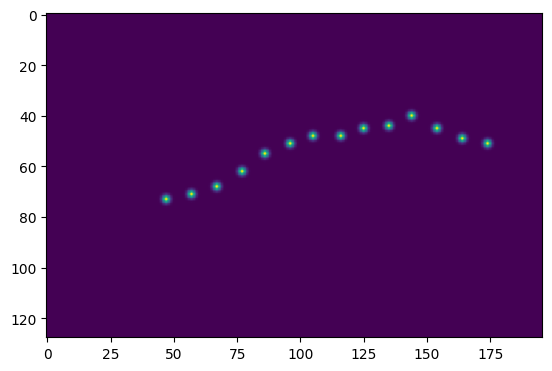

In [54]:
plt.imshow(hm)

In [55]:
# n_correct = 0
# for i in trange(len(indices)):
#     img, hm, n_points, _ = ds.__getitem__(i)
#     if torch.sum(hm > 0.7) == n_points:
#         n_correct += 1
# print(n_correct / len(indices))

In [56]:
h, w = hm.shape
pre_arr = np.ones_like(hm) * 100
pad = 1
y_pred_pad = np.pad(hm, ((pad, pad), (pad, pad)))
for y in range(pad, h+pad):
    for x in range(pad, w+pad):
        # (x, y)が中心の3*3のカーネルで、中心の値が一番大きい時のみ通過
        if not np.argmax(y_pred_pad[y-1:y+2, x-1:x+2]) == 4:
            score = 0.0
        else:
            score = y_pred_pad[y, x]

        pre_arr[y-pad, x-pad] = score

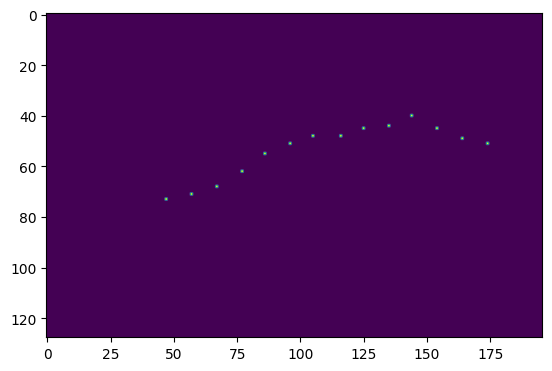

In [57]:
plt.imshow(pre_arr)

In [58]:
pre_arr.nonzero()

(array([40, 44, 45, 45, 48, 48, 49, 51, 51, 55, 62, 68, 71, 73]),
 array([144, 135, 125, 154, 105, 116, 164,  96, 174,  86,  77,  67,  57,
         47]))

In [59]:
xs, ys

(['1949.7',
  '1954.6',
  '1959.7',
  '1964.8',
  '1969.8',
  '1974.5',
  '1979.6',
  '1984.8',
  '1989.6',
  '1994.7',
  '1999.2',
  '2004.6',
  '2009.5',
  '2014.6'],
 ['53.8',
  '56.9',
  '64.3',
  '75.2',
  '88.7',
  '98.4',
  '102.7',
  '102.7',
  '108.8',
  '112.3',
  '118.5',
  '108.8',
  '101.9',
  '97.1'])

In [231]:
k_s = 5
kernel = np.zeros((k_s, k_s))
c = k_s // 2
for x in range(k_s):
    for y in range(k_s):
        kernel[x][y] = np.exp(- ((x - c) ** 2 + (y - c) ** 2) / (2 * cfg.sigma ** 2))

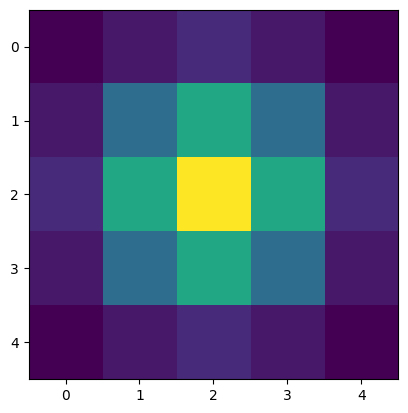

In [232]:
plt.imshow(kernel)

In [356]:
pred_kernel = np.zeros((5, 5))
pred_kernel[2, 2] = 1
pred_kernel[4, 4] = 1

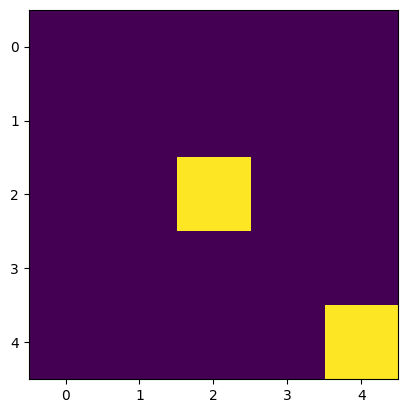

In [357]:
plt.imshow(pred_kernel)

In [358]:
p = np.ones((5, 5))

In [359]:
def calc_kl_divergence(pred_kernel, gt_kernel):
    p = np.clip(pred_kernel.flatten(), 1e-7, 1.0)
    p /= np.sum(p)
    q = np.clip(gt_kernel.flatten(), 1e-7, 1.0)
    q /= np.sum(q)
    kl_div = np.sum(np.where(p != 0, p * np.log(p / q), 0))
    return kl_div

In [360]:
a = np.array([0.1, 0.3, 1., 0.3, 0.1])
b = np.array([0., 0., 1., 0., 0.])

In [361]:
calc_kl_divergence(pred_kernel, kernel)

3.126357577275827

In [353]:
pred_kernel

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

In [422]:
map

array([[0.485, 0.485, 0.485, ..., 0.485, 0.485, 0.485],
       [0.485, 0.485, 0.485, ..., 0.485, 0.485, 0.485],
       [0.485, 0.485, 0.485, ..., 0.485, 0.485, 0.485],
       ...,
       [0.485, 0.485, 0.485, ..., 0.485, 0.485, 0.485],
       [0.485, 0.485, 0.485, ..., 0.485, 0.485, 0.485],
       [0.485, 0.485, 0.485, ..., 0.485, 0.485, 0.485]])

In [431]:
h, w = hm.shape

pad = 2
pre_arr = np.ones_like(hm) * 100
thr = 3.0

def _calc_kl_divergence(pred_kernel, gt_kernel):
    p = np.clip(pred_kernel.flatten(), 1e-7, 1.0)
    p /= np.sum(p)
    q = np.clip(gt_kernel.flatten(), 1e-7, 1.0)
    q /= np.sum(q)
    kl_div = np.sum(np.where(p != 0, p * np.log(p / q), 0))
    return kl_div

map_pad = np.pad(hm, ((pad, pad), (pad, pad)))

counter = 0

for y in range(pad, h+pad):
    for x in range(pad, w+pad):
        # (x, y)が中心の3*3のカーネルで、中心の値が一番大きい時のみ通過
        if not np.argmax(map_pad[y-1:y+2, x-1:x+2]) == 4:
            score = 100
        else:
            pred_kernel = map_pad[y-pad:y+pad+1, x-pad:x+pad+1]
            score = _calc_kl_divergence(
                pred_kernel, kernel)

        pre_arr[y-2, x-2] = score

        if score < thr:
            counter += 1

In [432]:
map_pad

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

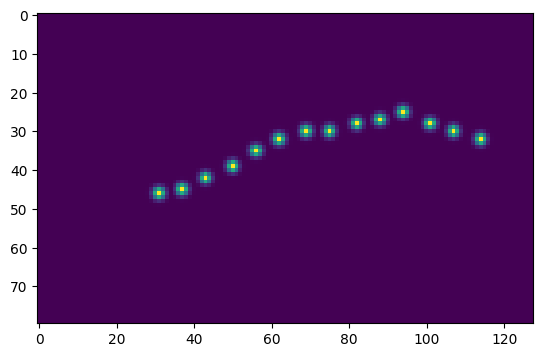

In [433]:
plt.imshow(hm)

In [434]:
pre_arr

array([[100., 100., 100., ..., 100., 100., 100.],
       [100., 100., 100., ..., 100., 100., 100.],
       [100., 100., 100., ..., 100., 100., 100.],
       ...,
       [100., 100., 100., ..., 100., 100., 100.],
       [100., 100., 100., ..., 100., 100., 100.],
       [100., 100., 100., ..., 100., 100., 100.]], dtype=float32)

In [435]:
counter

14

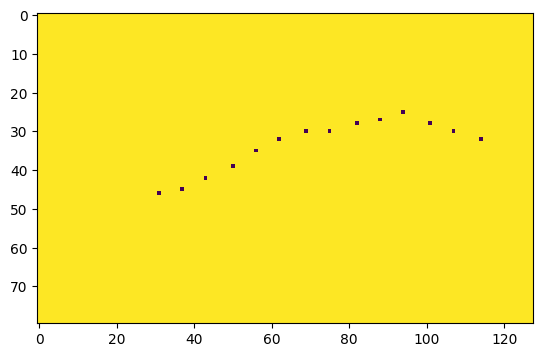

In [436]:
plt.imshow(pre_arr)

In [438]:
np.min(pre_arr)

-1.0710209e-07

In [392]:
hm[y-1:y+1][x-1:x+1]

tensor([], size=(0, 128))

In [375]:
hm.shape

(80, 128, 3)

In [1]:
hm

NameError: name 'hm' is not defined